# Warm start SVGP with equivalent observations and 'efficient' parametrisation...


In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import time

rng = np.random.RandomState(123)
tf.random.set_seed(42)

D = 5                   # input space dimension
N = 10000               # number of observation points
M = 1000                # number of inducing points
P = int(np.sqrt(M))     # number of blocks in the SSVGP param (ie num of submodels in the GP ensemble)
num_rep = 5

kernel =  gpflow.kernels.Matern32(lengthscales=[M**(-1/D)]*D)  # inducing points are roughly 1 lengthscale apart
gpflow.set_trainable(kernel, False)
gpflow.utilities.print_summary(kernel)

noise_var = 1e-2
lik = gpflow.likelihoods.Gaussian()
lik.variance.assign(noise_var)
gpflow.set_trainable(lik, False)
mean_function = gpflow.mean_functions.Zero()

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));


/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


╒═══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════╕
│ name                  │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                         │
╞═══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════╡
│ Matern32.variance     │ Parameter │ Softplus    │         │ False       │ ()      │ float64 │ 1.0                           │
├───────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────┤
│ Matern32.lengthscales │ Parameter │ Softplus    │         │ False       │ (5,)    │ float64 │ [0.25119, 0.25119, 0.25119... │
╘═══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════════════════════╛


2022-09-14 15:11:59.164130: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We generate samples from the prior distribution as test function.


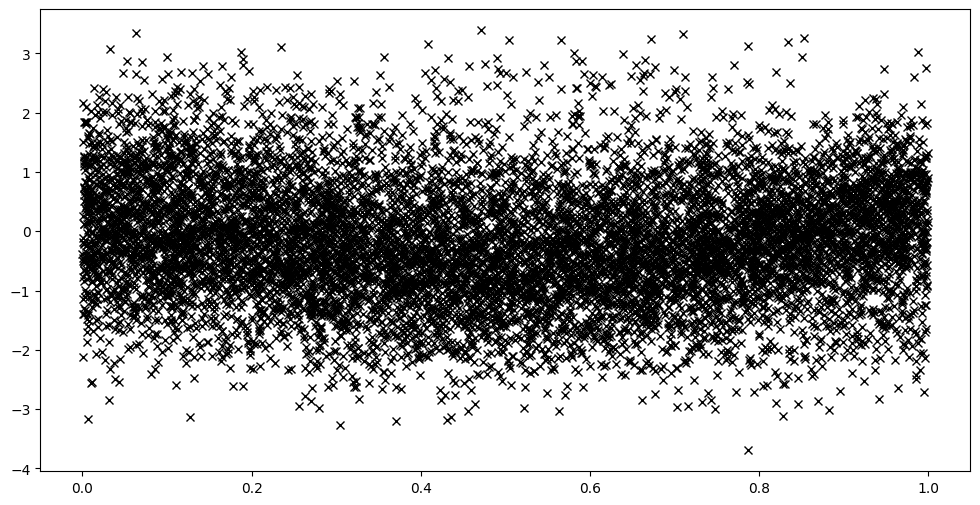

In [2]:
def make_data(num_rep, N, D, P):
    X = np.random.uniform(size=(num_rep, N, D))
    Z = np.empty((num_rep, M, D))
    Y = np.empty((num_rep, N, 1))
    for i in range(num_rep):
        dummy_data = np.array([[100.]]*D).T, np.array([[0.]])
        F = gpflow.models.GPR(dummy_data, kernel).predict_f_samples(X[i], 1).numpy()[0, :, :]
        Y[i] = F + np.random.normal(0, np.sqrt(noise_var), size=F.shape)
        Z[i], _ = scipy.cluster.vq.kmeans2(X[i], M, minit='points')
    return X, Y, Z

X, Y, Z = make_data(num_rep, N, D, P)
plt.plot(X[0, :, 0], Y[0, :, 0], "kx")

We fit a classic SVGP model with 50 inducing points taken uniformly in the input space

In [3]:
maxiter = 1000

def callback(x):
    global times
    global traces
    times += [time.time()]
    traces += [training_loss()]

rng = np.random.RandomState(123)

Times = np.nan * np.zeros((maxiter, num_rep))
Traces = np.nan * np.zeros((maxiter, num_rep))

for i in range(num_rep):
    print(f"{i}/{num_rep}")
    _, label_x = scipy.cluster.vq.kmeans2(X[i], Z[i])

    m = gpflow.models.SVGP(kernel, lik, Z[i], num_data=N, whiten=False)
    gpflow.set_trainable(m.inducing_variable, False)
    training_loss = m.training_loss_closure((X[i], Y[i]), compile=True)
    
    opt = gpflow.optimizers.Scipy()
    traces = []
    times = []
    start_time = time.time()
    opt.minimize(training_loss, m.trainable_variables, callback=callback, options={'maxiter':maxiter})
    Traces[:len(traces), i] = traces
    Times[:len(times), i] = [t - start_time for t in times]

Times_svgp = Times
Traces_svgp = Traces


0/5


2022-09-14 15:13:00.903319: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/5
2/5
3/5
4/5


Text(0.5, 1.0, 'SVGP: N = 10000, D = 5, M = 1000')

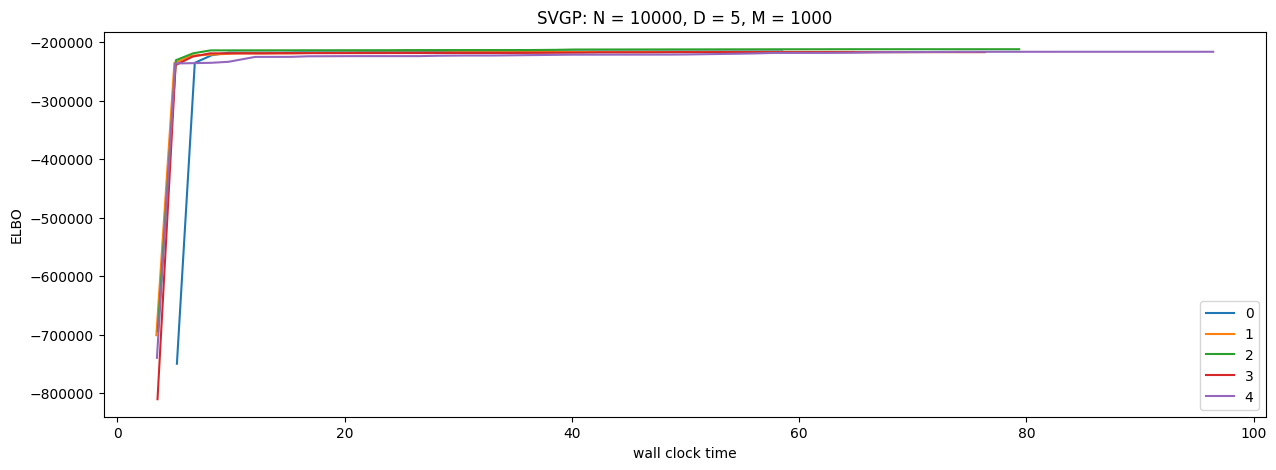

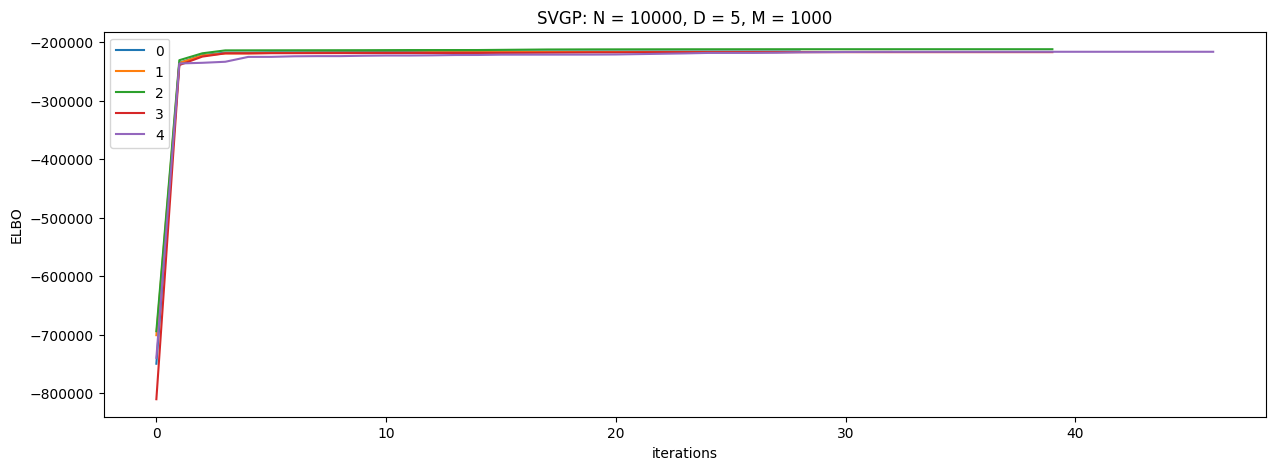

In [4]:
Times = Times_svgp
Traces = Traces_svgp

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(0, num_rep):
    plt.plot(Times[:, i], -Traces[:, i], label=i);
    plt.xlabel("wall clock time")
    plt.ylabel("ELBO")
    plt.title("SVGP")
    #plt.ylim(-500, 100)
plt.legend()
plt.title(f"SVGP: N = {N}, D = {D}, M = {M}")

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(0, num_rep):
    plt.plot(-Traces[:, i], label=i);
    plt.xlabel("iterations")
    plt.ylabel("ELBO")
    plt.title("SVGP")
    #plt.ylim(-500, 100)
plt.legend()
plt.title(f"SVGP: N = {N}, D = {D}, M = {M}")


Now, let's fit 50 SVGP with one inducing point each, use equivalent observations to merge the ensemble predicions and use the result to warm start an SVGP optimisation...

In [5]:
Times = np.nan * np.zeros((maxiter, num_rep))
Traces = np.nan * np.zeros((maxiter, num_rep))

for i in range(num_rep):
    print(f"{i}/{num_rep}")
    _, label_x = scipy.cluster.vq.kmeans2(X[i], Z[i])
    _, label_z = scipy.cluster.vq.kmeans2(Z[i], P, minit='points') 

    start_time = time.time()

    m_ensemble = []
    for j in range(P):
        mask_x = label_z[label_x] == j
        mask_z = label_z == j
        X_ = X[i, mask_x, :]
        Y_ = Y[i, mask_x, :]
        Z_ = Z[i, mask_z, :]

        m = gpflow.models.SVGP(inducing_variable=Z_, likelihood=lik, kernel=kernel, mean_function=mean_function, whiten=False)
        gpflow.set_trainable(m.inducing_variable, False)
        opt = gpflow.optimizers.Scipy()
        training_loss = m.training_loss_closure((X_, Y_), compile=True)
        opt_logs = opt.minimize(training_loss, m.trainable_variables, options={'maxiter':10});
        m_ensemble += [m]

    Zs, q_mus, q_sqrts = guepard.utilities.init_ssvgp_with_ensemble(m_ensemble, add_jitter=True) 
    m_ssvgp = guepard.SparseSVGP(kernel, lik, Zs, q_mus, q_sqrts, whiten=False)
    gpflow.set_trainable(m_ssvgp.inducing_variable, False)

    traces = []
    times = []
    training_loss = m_ssvgp.training_loss_closure((X[i], Y[i]), compile=True)
    opt = gpflow.optimizers.Scipy()

    # start_time = time.time() # TODO remove such a cheating shortcut so that timing accounts for submodel training...

    opt.minimize(training_loss, m_ssvgp.trainable_variables, callback=callback, options={'maxiter':maxiter})
    Traces[:len(traces), i] = traces
    Times[:len(times), i] = [t - start_time for t in times]

Times_ssvgp = Times
Traces_ssvgp = Traces


0/5
Instructions for updating:
Do not call `graph_parents`.
1/5
2/5
3/5
4/5


Text(0.5, 1.0, 'SSVGP: N = 10000, D = 5, M = 1000, P = 31')

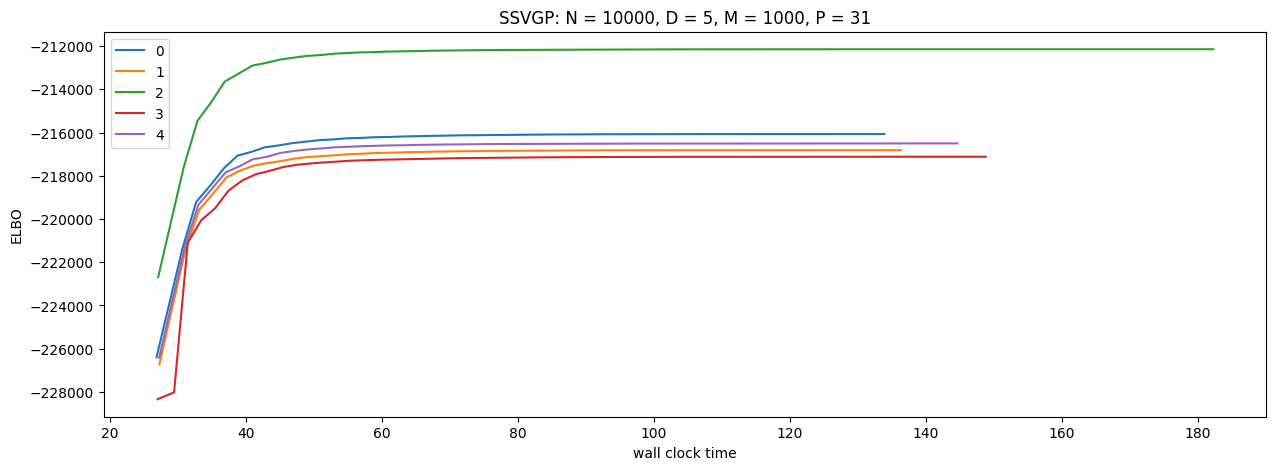

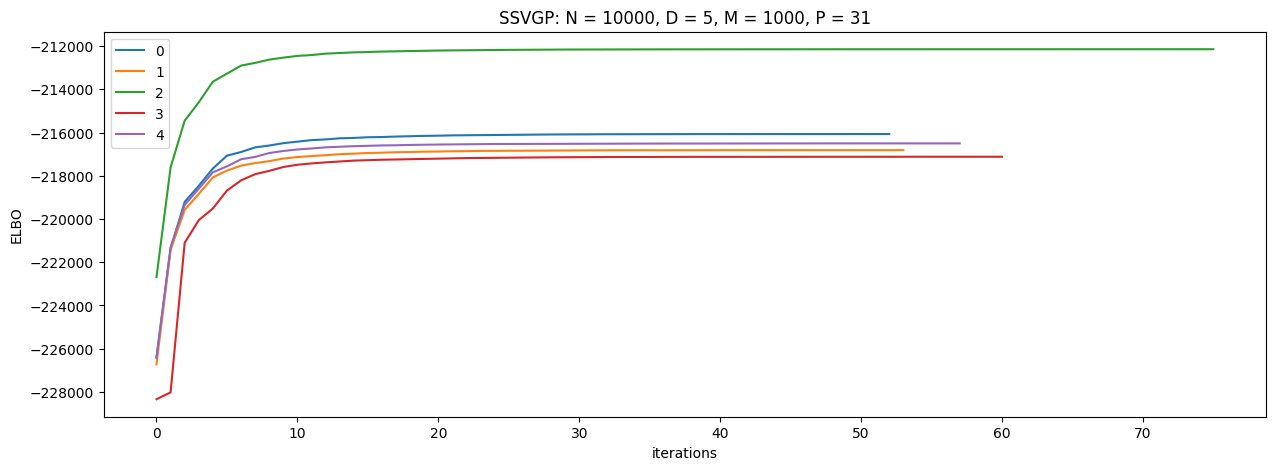

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(0, num_rep):
    plt.plot(Times[:, i], -Traces[:, i], label=i);
    plt.xlabel("wall clock time")
    plt.ylabel("ELBO")
    plt.title("SSVGP")
    #plt.ylim(-500, 100)
plt.legend()
plt.title(f"SSVGP: N = {N}, D = {D}, M = {M}, P = {P}")

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(0, num_rep):
    plt.plot(-Traces[:, i], label=i);
    plt.xlabel("iterations")
    plt.ylabel("ELBO")
    #plt.ylim(-500, 100)
plt.legend()
plt.title(f"SSVGP: N = {N}, D = {D}, M = {M}, P = {P}")


In [7]:
SGPR_evidence = []

for i in range(num_rep):
    print(f"{i}/{num_rep}")
    m = gpflow.models.SGPR((X[i], Y[i]), kernel, Z[i], noise_variance=noise_var)
    SGPR_evidence += [- m.elbo()]


0/5
1/5
2/5
3/5
4/5


Text(0.5, 1.0, 'N = 10000, D = 5, M = 1000, P = 31')

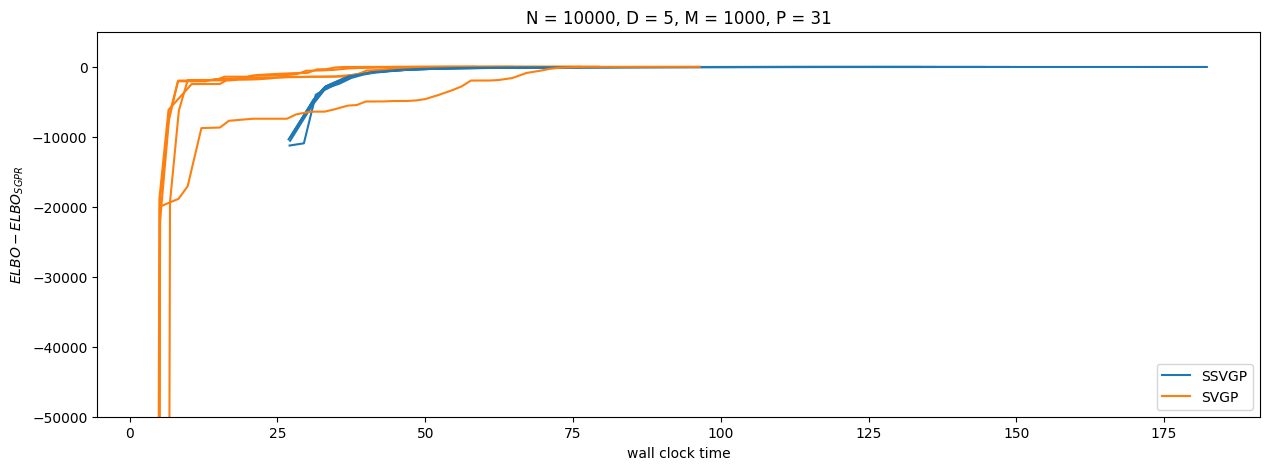

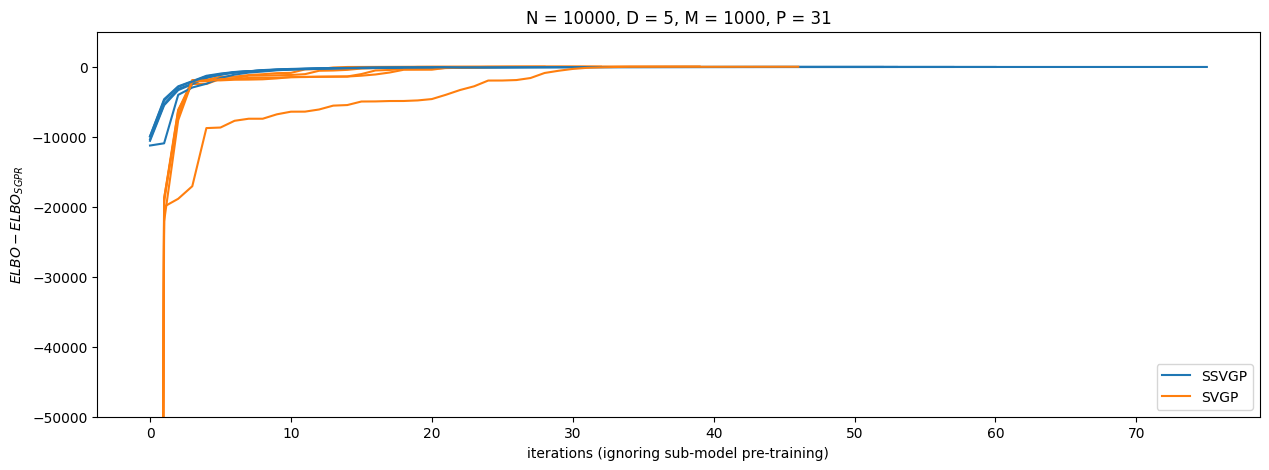

In [8]:
ylim = (-50000, 5000)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(0, num_rep):
    plt.plot(Times_ssvgp[:, i], -Traces_ssvgp[:, i] + SGPR_evidence[i], "C0", label="SSVGP" if i==0 else None);
    plt.plot(Times_svgp[:, i], -Traces_svgp[:, i] + SGPR_evidence[i], "C1", label="SVGP" if i==0 else None);
    plt.xlabel("wall clock time")
    plt.ylabel("$ELBO - ELBO_{SGPR}$")
    plt.ylim(ylim)

plt.legend()
plt.title(f"N = {N}, D = {D}, M = {M}, P = {P}")

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(0, num_rep):
    plt.plot(-Traces_ssvgp[:, i] + SGPR_evidence[i], "C0", label="SSVGP" if i==0 else None);
    plt.plot(-Traces_svgp[:, i] + SGPR_evidence[i], "C1", label="SVGP" if i==0 else None);
    plt.xlabel("iterations (ignoring sub-model pre-training)")
    plt.ylabel("$ELBO - ELBO_{SGPR}$")
    plt.ylim(ylim)
plt.legend()
plt.title(f"N = {N}, D = {D}, M = {M}, P = {P}")
